### Building a Tree Code II: Sorting in Three Dimensions

In this series of notebooks we will build a tree code for determining the acceleration from a set of "particles" (point masses) in $O(N\log N)$ time.

This is the first part, creating a set of particles, forming Morton keys, and sorting the particles into tree order.

In [ ]:
%matplotlib inline

# make notebook as wide as browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

from numba import jit, njit, uint32, uint64, float64
from numba.experimental import jitclass
import numba

import numpy.random as rng
rng.seed(24238929)

First we need a way of organizing our particle data. For each of our $N$ particles, at a minimum we will want to store the particles' positions, velocities, and masses. In practice, it is also useful to store the accelerations, the potential at each particle, and a particle "ID" we can use for various purposes.
 
We have two principal ways to organize and store this data. We could create a structure (class in Python) to hold one particle's data (the @dataclass decorator is described below)
```
@dataclass
class Particle:
    pos: np.ndarray  # array of (3)
    vel: np.ndarray  # array of (3)
    acc: np.ndarray  # array of (3)
    pot: float       # scalar
    mass: float      # scalar
    id: int          # scalar
```
and then create an array of length $N$ of these particle structures. This is known as an *array-of-structures*,
and would be accessed *e.g.* as ```particle[n].vel``` 

We could also create a single structure (class) which stores various arrays of particle data:
```
@dataclass
class Particle:
    pos: np.ndarray  # array of (N,3)
    vel: np.ndarray  # array of (N,3)
    acc: np.ndarray  # array of (N,3)
    pot: np.ndarray  # array of (N)
    mass: np.ndarray # array of (N)
    id: np.ndarray   # array of (N)
```
Here we have one class, and quantities are addressed as ```particles.vel[n]```. This format is known as the *structure-of-arrays*.

We've just used the decorator @dataclass, which automatically builds a function
```
class Foo:
    def __init__(self, center, halfWidth, ...):
        self.center = center
        self.halfWidth = halfWidth
        ...
```    
from
```
@dataclass
class Foo:
    center: np.ndarray
    halfwidth: float
    ...
```
Thus, a @dataclass is a class whose ```__init__``` function simply copies all of its arguments into class variables
(```self.```) with the given names.

We will have occasion to loop over the particle positions in a group when computing the acceleration. Because numpy arrays are so much faster for this sort of thing, we will choose the latter, though in the C++ example we'll see a more sophisticated approach.

We will include in our ParticleSet class some utility functions for working with the particle data, and try to make things work a bit faster by using the Numba just-in-time (JIT) compiler:

In [ ]:
pset_spec = [
    ('N', uint32),
    ('pos', float64[:,:]),
    ('vel', float64[:,:]),
    ('acc', float64[:,:]),
    ('pot', float64[:]),
    ('mass', float64[:]),
    ('id', uint32[:]),
    ('boxMin', float64[:]),
    ('boxMax', float64[:]),
    ('center', float64[:]),
    ('halfWidth', float64)
]

@jitclass(pset_spec)
class ParticleSet(object):
    def __init__(self, N):
        self.N = N
        self.pos  = np.zeros((N,3), dtype=np.float64)
        self.vel  = np.zeros((N,3), dtype=np.float64)
        self.acc  = np.zeros((N,3), dtype=np.float64)
        self.pot  = np.zeros(N,     dtype=np.float64)
        self.mass = np.zeros(N,     dtype=np.float64)
        self.id   = np.zeros(N,     dtype=np.uint32)

    # permute the paticle set according to a permutation array
    # (used for sorting the particles)
    def permute(self, index):
        self.pos[:,:]  = self.pos[index,:]
        self.vel[:,:]  = self.vel[index,:]
        self.acc[:,:]  = self.acc[index,:]
        self.pot[:]  = self.pot[index]
        self.mass[:] = self.mass[index]
        self.id[:]  = self.id[index]

    # find the bounding box for the particles stored in this set
    def boundingCube(self):
        self.boxMin = np.min(self.pos) * np.ones(3) * (1-2.2e-10)  # keep bounding box larger than particles' range
        self.boxMax = np.max(self.pos) * np.ones(3) * (1+2.2e-10)
        self.center = 0.5*(self.boxMax + self.boxMin)
        self.halfWidth = 0.5*(self.boxMax[0]-self.boxMin[0])

Next, create a particle set to play with. All we will need for now are some positions, most easily generated in a uniform distribution:

In [ ]:
N = 100000
p = ParticleSet(N)
p.pos[:,:] = rng.rand(N,3)
p.boundingCube()
print(f"{p.boxMin} : {p.boxMax}")
print(f"{p.center}  {p.halfWidth}")

<hr style="background-color: rgb(0,0,0);height: 2.0px;"/>

Now we get to group-finding. The most efficient way to search an ordered list in 1D is *binary search*. At each stage in a binary search we divide the search space into two halves, decide which half has our point, and repeat
until we have narrowed down the search space to our target. For a list of length $N$, we will have to repeat this process $O(\log_2 N)$ times. This is just the way someone naturally looks up a word in a dictionary.

Barnes and Hut used a natural extension of binary search to N dimensions (three in our case). If we start by determining the *bounding box* for our particles (the cube which just encloses all of the particles), we can subdivide this box in two *in each dimension*. Thus, in 3D we divide the bounding box into eight octants, and then recurse down dividing each octant into eight octants, and so on.

We can represent this organization of octants as a graph, known as an *octree* (here presented for a *quadtree* in 2D):


<div>
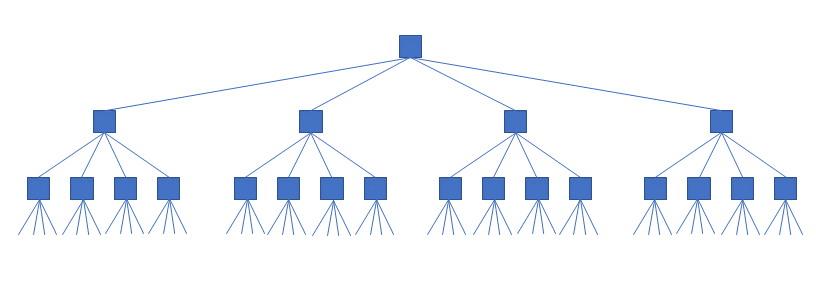
</div>

The top of the graph, corresponding to the bounding box of our problem, is known as the *root* of the tree. Each of the *children* of the root, and their children, etc. are *nodes* in the tree. The bottom-most nodes, those which contain one particle, are the *leaf nodes*. As we shall see, it usually doesn't pay to build a tree all the way down to one-particles leaves; we usually define a parameter maxLeafSize to tell the algorthm to stop subdividing nodes when their *population* is fewer than maxLeafSize. (You will not be the first to note that, in computer science, tree have their roots on top and their leaves on the bottom!)

By storing information about our hierarchically-subdivided cells as the graph of a tree, we can easily *travese* the tree by following the *edges* of the graph connecting the nodes. More on this shortly...

First, remember that binary search only works on an *ordered* list, so we will need a multidimensional version of ordering. One version is *Morton* (or Lesbesgue) ordering. An ordering is a way to assign an integer to objects so that they may be sorted into order. Morton ordering works as follows:

Make an integer representation of the x-, y-, and z-coordinates of our particles. Say the particles have a bounding box $[0,1)^3$ (we can always rescale their coordinates to make this so). We can then multiply these scaled coodinates by, say $2^32$, so that their integer representation will fit into a 4-byte integer. The lower half of the x-coordinates will have a 0 as their most-significant bit, and the upper half of the x-coordinates will have a 1. The same will be true in the y- and z-directions. Thus, if we make a 3-bit (octal) number from the first bits of
x, y, and z, we will have a number between 0 and 7. In Morton ordering, this number tells us in which octant of the bounding box the particle lies. 

We then move on to using the second bits of the three coordinate directions. This gives us in which of the child octants the particle lies, and so on. Thus, by interleaving the bits $x_1y_1z_1x_2y_2z_2x_3y_3z_3\dots$ we have the "address" of the lowest-level octant in our tree where the particle can be found. Taking three bits at a time, we know which octant to go to in the next level of the tree in three dimensions.

If we then sort the particles w/r to their Morton keys, all of the particles in a given node of the tree will be adjacent in the list, *at all levels in the tree*. This is Morton ordering.



<hr style="background-color: rgb(0,0,0);height: 2.0px;"/>

Morton keys are constructed by interleaving the bits of integer representations of the coordinates after shifing and scaling them onto $[0,1)^3$.

Create a scaled set of coordinates on the interval $[0,1)^3$

In [ ]:
rp = (p.pos-p.boxMin)/(p.boxMax-p.boxMin)
np.min(rp, axis=0), np.max(rp, axis=0)

We can now write a function to compute the Morton key of one of these scaled coordinates. If we assume 42 bits per dimension, the 3D Morton key will be 126 bits long, and this fits nicely in a 128-bit integer.

This corresponds to a tree of maximum depth 42, where the linear size of the smallest cell is $2^{-42} \approx 2.3\times10^{-13}$ in scaled coordinates, sufficient dynamic range for most purposes (though not all!).

To start, let our key be an array of 42 bytes, one byte for each level in the tree. At each level, we compute the coordinate of the midpoint of the cell containing a particle's position, call it $\mathbf{c}$, and at each level, ask if the coordinate is greater or less than the cell center. Represent this by 3 bits for 3 dimensions. 

In the following, the operator in the expression ```a<<b``` is "shift left" -- move all bits of $a$ to the left by $b$.

The operator $|$ is bitwise-or, so that ```0100 | 0010``` results in $0110$

Thus

In [ ]:
print(f" 1<<4 = {(1<<4):06b}")
print(f" 0101 << 3 = {0b0101 << 3:08b}")
print(f" 0100 | 0010 = {0b0100 | 0b0010:04b}")

Our Morton key function is then

In [ ]:
def makeKeyArray(pos):
    
    c = 0.5*np.ones(3)  # center of the root; the whole box
    r = 0.25            # radius of cells at the first level (octants)
    
    key = np.zeros(42, dtype='u8')  # unsigned 8-bit integers
    for level in range(42):
        oct = 0
        for d in range(3):
            if pos[d] >= c[d]:
                oct |= (1<<d)  # set bit d of o to one
                c[d] += r
            else:
                c[d] -= r    # set bit d of o to zero (by ignoring it!)
        key[level] = oct
        r *= 0.5
    return key

def printKeyArrayBinary(key):
    for level in range(42): print(f"{key[level]:>03b} ", end="")

Let's look at the key for the first point in our set; we'll print them out by *octs* so that the addressing function of the Morton
key is more obvious

In [ ]:
key = makeKeyArray(rp[0])
printKeyArrayBinary(key)

Binary keys are a bit cumbersome to look at; let's print the key as octal (base-8) digits. Each octal digit is the key at one level:

In [ ]:
def printKeyArray(key):
    for level in range(42): print(f"{key[level]:>3o} ", end="")
printKeyArray(key); print()
printKeyArrayBinary(key)

Draw the boxes for the first 5 levels for a few points

In [ ]:
def drawKeyCell(key, pos, ax):
    c = 0.5*np.ones(3)
    r = 0.5
        
    for level in range(5):
        ax.add_artist(Rectangle(c-r, width=2*r, height=2*r, fill=False))

        r *= 0.5
        for d in range(3):
            k = int(key[level])
            if int(key[level])&(1<<d):
                c[d] += r
            else:
                c[d] -= r


fig, ax = plt.subplots()
ax.set_xlim(-0.2, 1.2)
ax.set_ylim(-0.2, 1.2)
for i in range(4):
    pos = rp[i]
    key = makeKeyArray(rp[i])
    ax.plot(pos[0], pos[1], '.')
    drawKeyCell(key, pos, ax)
ax.set_axis_off()

Our key in the previous example is $42\times8=336$ bits long, but it really only needs to be 126 bits long. We can
improve things by storing the key as bits. All it will take is some *bit-twiddling* (a technical term!):

In [ ]:
def makeKeyBinary(pos: np.ndarray) -> int:
    c = 0.5*np.ones(3)
    r = 0.25
    
    offset = 3*(42-1) # how much to shift left the most-significant bit
    key = 0
    for level in range(42):
        oct = 0
        for d in range(3):
            if pos[d] >= c[d]:
                oct |= (1<<d)
                c[d] += r
            else:
                c[d] -= r
        key |= oct<<(offset-3*level)
        r *= 0.5
        
    return key

In [ ]:
def printKeyArray(key):
    for level in range(42): print(f"{key[level]:>1o}", end="")

keyArray = makeKeyArray(rp[0,:])
printKeyArray(keyArray); print()

keyBinary = makeKeyBinary(rp[0])
print(f"{keyBinary:042o}")

This is better, but it is still not very fast. Since we want to be able to run millions of particles and need to do this every time step, there is a permium on speed.

Here is a method which uses only one loop, over dimension:

In [ ]:
# some constants
m1  = 0x3ffffffffff
c64 = 0x3ff0000000000000000ffffffff
c32 = 0x3ff00000000ffff00000000ffff
c16 = 0x30000ff0000ff0000ff0000ff0000ff
c8  = 0x300f00f00f00f00f00f00f00f00f00f
c4  = 0x30c30c30c30c30c30c30c30c30c30c3
c2  = 0x9249249249249249249249249249249

def makeKey(pos):
    """
    Make a morton key as a binary number using bit-twiddling tricks
    """
    # assume that pos is on [0,1)
    p = (pos*((1<<42)))
    key = 0
    for d in range(3):
        r = int(p[d])
        r &= m1;
        r = (r | (r << 64)) & c64
        r = (r | (r << 32)) & c32
        r = (r | (r << 16)) & c16
        r = (r | (r << 8))  & c8
        r = (r | (r << 4))  & c4
        r = (r | (r << 2))  & c2
        key |= (r<<d)
    return key

Let's make sure all these methods give the same answer!

In [ ]:
print(f"position: {rp[0]}")

keya = makeKeyArray(rp[0]) 
keyb = makeKeyBinary(rp[0])
keyc = makeKey(rp[0])  

print(" array: 0o",end="")
for i in range(42): print("{:o}".format(keya[i]), end="")
print()
print("binary: {:#034o}".format(keyb))
print("  fast: {:#034o}".format(keyc))
assert( keyc == keyb )

print("\n")

Time the three versions:

In [ ]:
%timeit makeKeyArray(rp[0])
%timeit makeKeyBinary(rp[0])
%timeit makeKey(rp[0])

```makeKey``` is clearly the fastest without numba, but it would be better to be able to compile this function.

Sadly, we cannot use numba.njit because neither numba nor numpy has support for 128-bit integers. Perhaps cython
can be tricked into using 128 integers, but I haven't tried this yet...

Numba successfully compiles makeKeyBinary, but it gives the wrong answer!

So, we will make the bit-twiddling version into a Morton class for use later. We'll put the scaling onto $[0,1)^3$ into the Morton
class itself, and provide a function ```getOct(key,level)``` which returns the oct at level in the key.

In [ ]:
class Morton():
    """
    Morton key class for sorting particles according to Z-order
    """
    def __init__(self, boxMin, boxMax):
        self.boxMin = boxMin
        self.scale = 1/(boxMax - boxMin)
        # some constants
        self.m1  = 0x3ffffffffff
        self.c64 = 0x3ff0000000000000000ffffffff
        self.c32 = 0x3ff00000000ffff00000000ffff
        self.c16 = 0x30000ff0000ff0000ff0000ff0000ff
        self.c8  = 0x300f00f00f00f00f00f00f00f00f00f
        self.c4  = 0x30c30c30c30c30c30c30c30c30c30c3
        self.c2  = 0x9249249249249249249249249249249

        # x-coordinate in Morton key changes most rapidly
        self.mask = np.array([ [-1,-1,-1],
                               [ 1,-1,-1],
                               [-1, 1,-1],
                               [ 1, 1,-1],
                               [-1,-1, 1],
                               [ 1,-1, 1],
                               [-1, 1, 1],
                               [ 1, 1, 1] ])
    def makeKey(self, pos):
        """
        Make a morton key as a binary number using bit-twiddling tricks
        """
        pscaled = (pos-self.boxMin) * self.scale
        # assume that pos is on [0,1)
        p = (pscaled*((1<<42)))
        key = 0
        for d in range(3):
            r = int(p[d])
            r &= self.m1
            r = (r | (r << 64)) & self.c64
            r = (r | (r << 32)) & self.c32
            r = (r | (r << 16)) & self.c16
            r = (r | (r << 8))  & self.c8
            r = (r | (r << 4))  & self.c4
            r = (r | (r << 2))  & self.c2
            key |= (r<<d)
        return key

    # get the octal value for level from key
    def getOct(self, key, level):
        shr = 123-3*(level)
        return (key>>shr)&7


In [ ]:
morton = Morton(p.boxMin, p.boxMax)

keya = makeKeyArray(rp[0])       # these functions need the scaled coordinates
keyb = makeKeyBinary(rp[0])
keyc = morton.makeKey(p.pos[0])  # The class does the scaling for us

print(" array: 0o",end="")
for i in range(42): print("{:o}".format(keya[i]), end="")
print()
print("binary: {:#034o}".format(keyb))
print("  fast: {:#034o}".format(keyc))
assert( keyc == keyb )

print("exercise getOct:")
print("   rec: 0o",end="")
for i in range(42):
    o = morton.getOct(keyc, i)
    print("{:o}".format(o),end="")
print()

Armed with the ability to make Morton keys, we can create the keys and then use them to sort the particles into Morton order.
First make the keys for all particles in our ParticleSet:

To sort on the keys, we will use Numpy's function ```np.argsort```, which returns a permutation vector such that
```
index = np.argsort(stuff)
sortedstuff = stuff[index]
```
is in sorted order, without changing the order of stuff.

If we get the permutation vector from sorting the keys, we can then use it to sort all of the arrays in our particle set.

While we are at it, lets compute the reverse permutation which brings everything back to the original order:

In [ ]:
stuff = rng.rand(10)
print(f"stuff:\n{stuff}")
index = np.argsort(stuff)
print(f"index:\n{index}")
sortedstuff = stuff[index]
print(f"sortedstuff:\n{sortedstuff}")
rindex = np.zeros(10, dtype=np.int32)
rindex[index] = np.arange(10)
print(f"rindex:\n{rindex}")
back = sortedstuff[rindex]
print(f"back:\n{back}")
np.allclose(stuff, back)

Doing this for our particle set p, we need to make sure we permute the keys to keep them
in the same order as the particles.

In [ ]:
# sort the keys, finding the permutation
index = np.argsort(keys)
# get the inverse permutation to put them back
rindex = np.empty(N, dtype=np.uint32)
rindex[index] = np.arange(N, dtype=np.uint32)

# permute the particles and their keys into Morton order
p.permute(index)
keys[:] = keys[index]

# check that the keys are sorted and that the positions are in ascending Morton order
for i in range(p.N-1):
    assert keys[i+1]>keys[i]
    assert morton.makeKey(p.pos[i+1]) > morton.makeKey(p.pos[i]) 
print("OK")

In the next notebook we will build the tree from these sorted Morton keys.